In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.constants import c, m_e, e, epsilon_0, hbar

from qsa_pwfa.simulation import Simulation
from qsa_pwfa.external_fields import GaussianBeam
from qsa_pwfa.species import NeutralUniformPlasma
from qsa_pwfa.species import GaussianBunch
from qsa_pwfa.diagnostics import FieldDiagnostics, BunchDiagnostics

n_plasma = 1e17 * 1e6
k_p_inv = (e**2 / m_e /  c**2  / epsilon_0 * n_plasma)**-0.5
field_dim = c**2 * m_e / e / k_p_inv

In [2]:
# Beam driver
n_b = 16.
R_b = 0.25
ksi0 = 2.5
R_xi = 0.25
gamma_b = 1000
dt_drv = 2 * np.pi * (2 * gamma_b)**.5 / 20

# Beam trailing
n_b2 = 1.
R_b2 = 0.1
ksi02 = 6.5
R_xi2 = 0.1
gamma_b2 = 200
dt_trail = 2 * np.pi * (2 * gamma_b2)**.5 / 20


delta_gamma_rel = 0.005
delta_theta = 4e-4

# plasma
L_xi = 11.
L_r = 5.

# grid
N_xi = 512 * 2
N_r = 512 * 2

d_xi = L_xi / N_xi
dr = L_r / N_r

Q_tot = n_b * (2*np.pi)**1.5 * (k_p_inv*R_b)**2 * (k_p_inv*R_xi) * 1e23 * e * 1e12
print(Q_tot)

Q_tot = n_b2 * (2*np.pi)**1.5 * (k_p_inv*R_b2)**2 * (k_p_inv*R_xi2) * 1e23 * e * 1e12
print(Q_tot)

299.3696163506162
1.1974784654024646


In [3]:
sim = Simulation(L_xi=L_xi, N_xi=N_xi, dt=dt_trail,verbose=0)
sim.add_specie( NeutralUniformPlasma(L_r=L_r, N_r=N_r,n_p=1.) )

#sim.add_external_field(GaussianBeam(n_b, R_b, ksi0, R_xi))
sim.add_specie( GaussianBunch( sim, n_b, R_b, R_xi, ksi0, 
                               Nr=2048, gamma_b=gamma_b, q=-1, 
                               delta_gamma=delta_gamma_rel*gamma_b,
                               eps_r=delta_theta*gamma_b*R_b,
                             ) )

sim.add_specie( GaussianBunch( sim, n_b2, R_b2, R_xi2, ksi02, 
                               Nr=2048, gamma_b=gamma_b2, q=-1, 
                               delta_gamma=delta_gamma_rel*gamma_b2,
                               eps_r=delta_theta*gamma_b2*R_b2,
                             ) )


sim.diagnostics = [ 
    FieldDiagnostics( sim, L_r=L_r/2, N_r=N_r,
                      fields=['Density', ], 
                      xi_step=2, 
                      ),
    BunchDiagnostics( sim, sim.species[-1], 
                         fields=['p_z','p_r'],
                         xi_step=1 )
    ]

sim.run_steps( 20, iter_max=50, rel_err_max=2e-2, 
               mixing_factor=0.05,
               track_convergence=True)

  0%|          | 0/20460 [00:00<?, ?it/s]

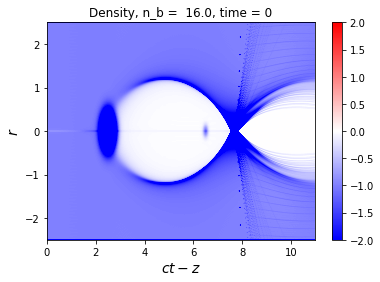

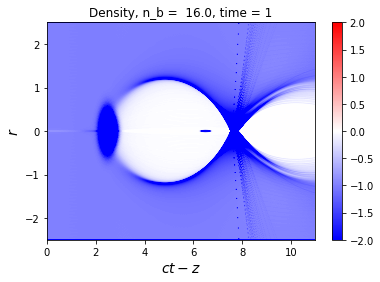

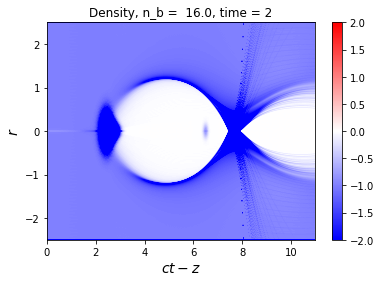

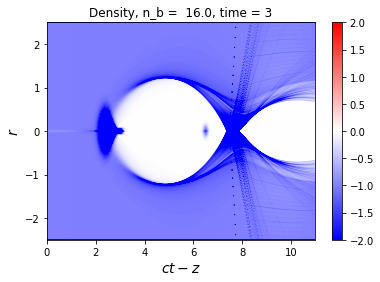

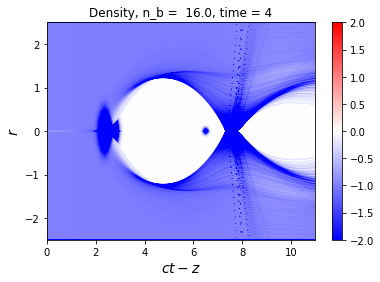

In [4]:
diag = sim.diagnostics[0]
ext = np.array([ diag.xi.min(),
                 diag.xi.max(),
                -diag.grid.rmax,
                 diag.grid.rmax ]) 

for fld in diag.fields: 
    for i_t, outout in enumerate(diag.outputs[::4]):
        val = outout[fld]
        val_ext = np.hstack((val[:,1:][:,::-1], val[:,1:]))

        plt.figure()

        vmax = 2
        plt.imshow(val_ext.T,
                origin='lower',
                aspect='auto',
                cmap=plt.cm.bwr,
                vmax=vmax,
                vmin=-vmax,
                extent=ext
                )

        plt.colorbar()
        plt.xlabel(r'$ct-z$', fontsize=14)
        plt.ylabel(r'$r$', fontsize=14)

        plt.title(f"{fld}, n_b =  {n_b}, time = {i_t}")

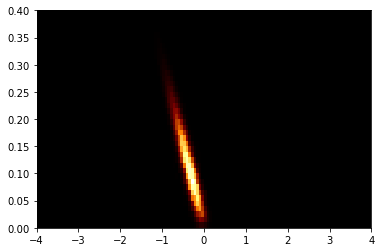

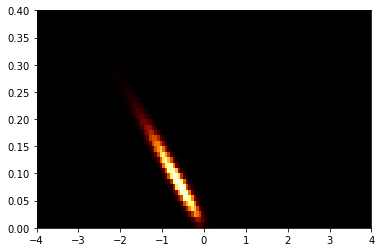

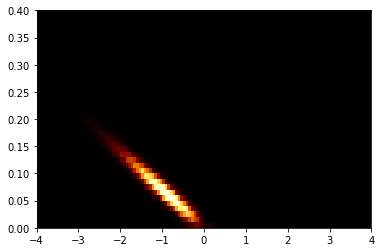

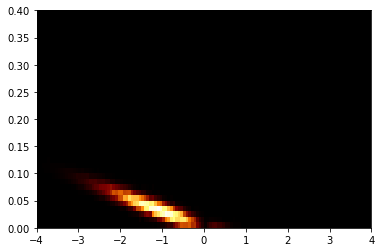

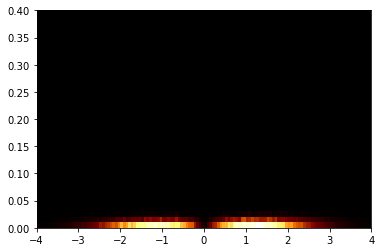

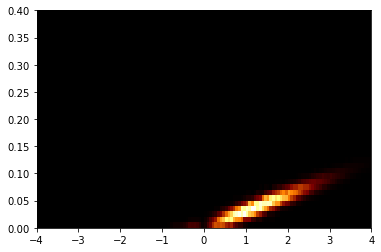

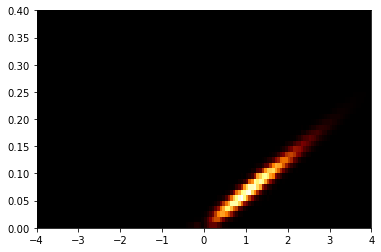

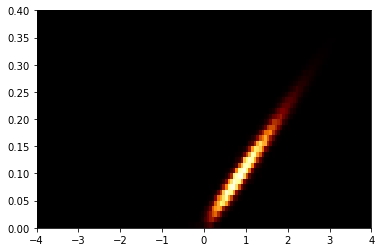

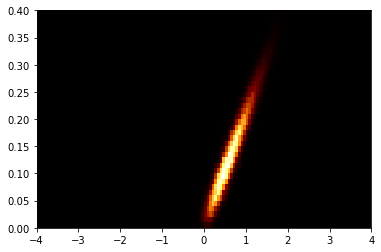

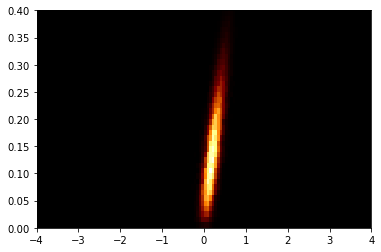

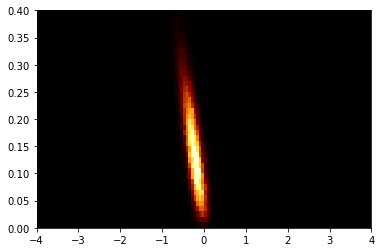

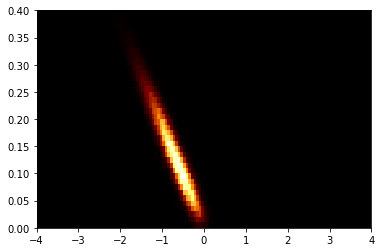

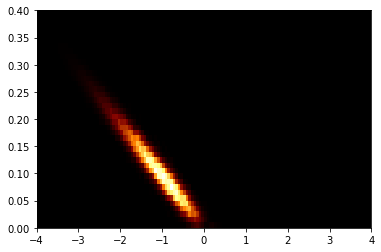

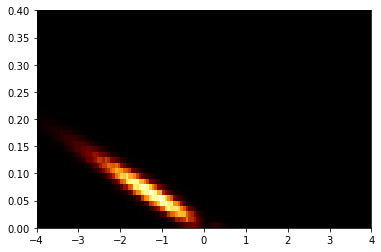

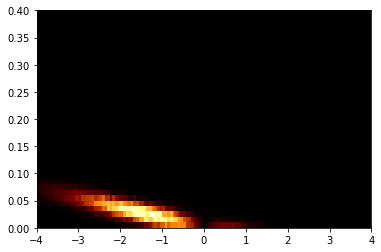

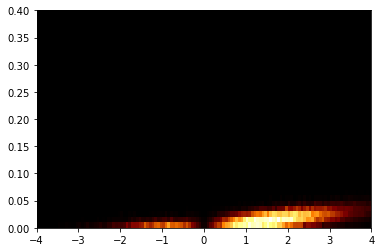

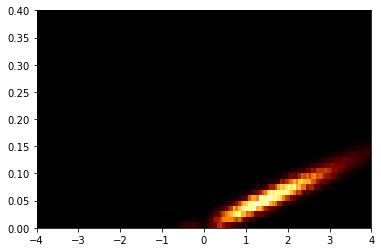

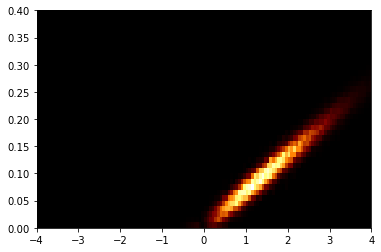

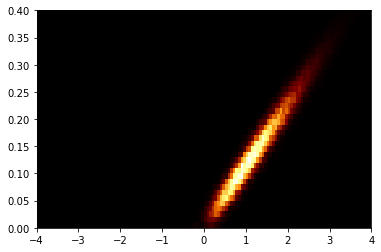

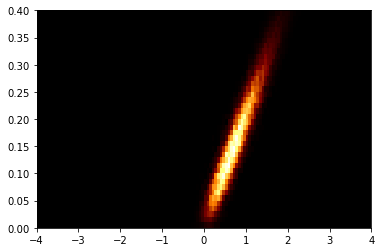

In [5]:
for outout in sim.diagnostics[-1].outputs:
    r, pr, w = outout['r'][:-1].flatten(), \
        outout['p_r'][:-1].flatten(), \
        outout['dQ'][:-1].flatten()

    plt.figure()
    plt.hist2d(pr, r, weights=w, bins=(128, 40),
              range=[[-4,4],[0,0.4]], cmap=plt.cm.afmhot_r);

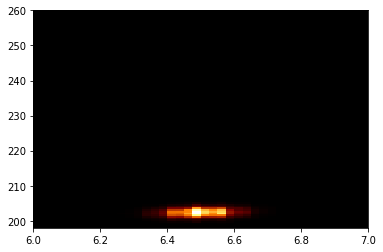

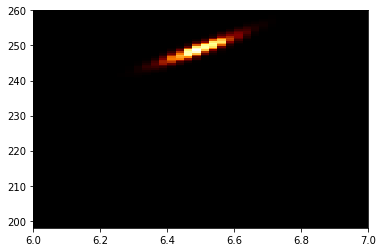

In [9]:
for outout in np.array(sim.diagnostics[-1].outputs)[[0,-1]]:

    z, pz, w = outout['xi'][:-1].flatten(), \
        outout['p_z'][:-1].flatten(), \
        outout['dQ'][:-1].flatten()

    plt.figure()
    plt.hist2d(z, pz, weights=w, bins=(40, 128),
               range=[[6,7],[198,260]],
               cmap=plt.cm.afmhot_r );